Colab에서 구글드라이브 연결하기

In [66]:
#Colab 에서 구글 드라이브 연결하기

from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [67]:

#파일 확인
!ls "/content/gdrive/My Drive/ml-100k"

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


Pytorch 사용하기

In [68]:
#필요한 모듈 import 하기
import torch
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt

파일 불러오기

In [69]:
#판다스를 이용해 파일 불러오기

train = pd.read_csv("/content/gdrive/My Drive/ml-100k/ua.base", \
                    sep="\t", names=['user', 'movie', 'rating', 'timestamp'])
test = pd.read_csv("/content/gdrive/My Drive/ml-100k/ua.test",\
                   sep="\t", names=['user', 'movie', 'rating', 'timestamp'])

In [70]:
train #tes 

,user,movie,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712
...,...,...,...,...
90565,943,1047,2,875502146
90566,943,1074,4,888640250
90567,943,1188,3,888640250
90568,943,1228,3,888640275


In [71]:
#pytorch tensor 데이터로 변환

items = torch.LongTensor(train['movie'])
users = torch.LongTensor(train['user'])
ratings = torch.FloatTensor(train['rating'])
items_test = torch.LongTensor(test['movie'])
users_test = torch.LongTensor(test['user'])
ratings_test = torch.FloatTensor(test['rating'])

In [72]:
items.shape

torch.Size([90570])

Latent Factor Model

In [79]:
rank = 10 #사용자 vector, 아이템 vector의 차원
numItems = items.max() + 1  #사용자수
numUsers = users.max() + 1  #아이템수
P = torch.randn(numItems, rank, requires_grad=True) #아이템 메트릭스 
Q = torch.randn(numUsers, rank, requires_grad=True) #사용자 메트릭스



#기본 MatrixFactorization구현

# Matplotlib으로epoch마다TrainingMSE그려보기
X = []
Y = []
Y_test=[] # Matplotlib으로 epoch마다 TestMSE 그려보기


optimizer = torch.optim.Adam([P, Q], lr= 0.1)
for epoch in range(1001):
  hypothesis = torch. sum(P[items] * Q[users], dim= 1) #해당하는 행 뽑기 -> 내적
  cost = F.mse_loss(hypothesis ,ratings)
  optimizer.zero_grad()
  cost.backward()
  optimizer.step()
  X.append(epoch)
  Y.append(cost) #training mse

    
  with torch.no_grad():
    hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1)
    cost_test = F.mse_loss(hypo_test, ratings_test)
    Y_test.append(cost_test)
  if epoch % 100 == 0: 
    print("epoch: {}, cost: {:.6f}, cost_test: {:.6f}".format(epoch, cost.item(), cost_test.item()))

epoch: 0, cost: 23.650812, cost_test: 21.813360
epoch: 100, cost: 0.562305, cost_test: 1.552424
epoch: 200, cost: 0.494726, cost_test: 1.917310
epoch: 300, cost: 0.471656, cost_test: 2.289806
epoch: 400, cost: 0.460840, cost_test: 2.740892
epoch: 500, cost: 0.454906, cost_test: 3.213548
epoch: 600, cost: 0.451151, cost_test: 3.693202
epoch: 700, cost: 0.448623, cost_test: 4.199843
epoch: 800, cost: 0.446755, cost_test: 4.792762
epoch: 900, cost: 0.445324, cost_test: 5.457215
epoch: 1000, cost: 0.444149, cost_test: 6.122405


In [80]:
#test


print(P[1])
print(Q[1])
print((P[1]*Q[1]).sum())

tensor([-0.7987,  0.3445,  0.7384, -0.3411,  1.3280,  0.4982, -0.3092,  0.4111,
        -0.8127,  0.6999], grad_fn=<SelectBackward>)
tensor([-1.2966, -0.3319,  0.5827, -0.1542,  0.6803,  0.9905,  0.0605,  0.3555,
        -1.1026,  0.4204], grad_fn=<SelectBackward>)
tensor(4.1188, grad_fn=<SumBackward0>)


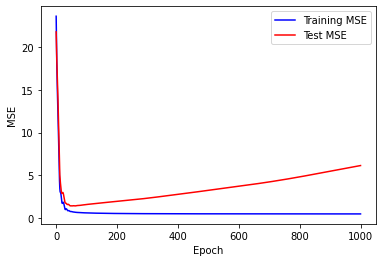

In [81]:
# Matplotlib으로epoch마다TrainingMSE그려보기

plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.plot(X,Y_test,c="red",label="Test MSE")
plt.legend()
plt.show()

In [82]:
print((P**2).sum())
print((Q**2).sum())

tensor(29771.0273, grad_fn=<SumBackward0>)
tensor(14372.4590, grad_fn=<SumBackward0>)


Regularization

In [83]:
rank = 10 #사용자 vector, 아이템 vector의 차원
numItems = items.max() + 1  #사용자수
numUsers = users.max() + 1  #아이템수
P = torch.randn(numItems, rank, requires_grad=True) #아이템 메트릭스 
Q = torch.randn(numUsers, rank, requires_grad=True) #사용자 메트릭스



#기본 MatrixFactorization구현

# Matplotlib으로epoch마다TrainingMSE그려보기
X = []
Y = []
Y_test=[] # Matplotlib으로 epoch마다 TestMSE 그려보기

# Regularization 추가하기
lambda1 = 0.0001
lambda2 = 0.0001

optimizer = torch.optim.Adam([P, Q], lr= 0.1)
for epoch in range(1001):
  hypothesis = torch. sum(P[items] * Q[users], dim= 1) #해당하는 행 뽑기 -> 내적
  mse = F.mse_loss(hypothesis ,ratings)
  
  cost = mse+lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2)
  optimizer.zero_grad()
  cost.backward()
  optimizer.step()
  X.append(epoch)
  Y.append(mse.item()) #training mse
  
   
  with torch.no_grad():
    hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1)
    mse_test = F.mse_loss(hypo_test, ratings_test)
    Y_test.append(mse_test.item())
  if epoch % 100 == 0: 
    print("epoch: {}, mse: {}, mse_test: {}" .format(epoch, mse,mse_test))

epoch: 0, mse: 23.6114501953125, mse_test: 21.964406967163086
epoch: 100, mse: 0.6726987957954407, mse_test: 1.04421865940094
epoch: 200, mse: 0.637549102306366, mse_test: 1.0567642450332642
epoch: 300, mse: 0.6305875182151794, mse_test: 1.0603175163269043
epoch: 400, mse: 0.6278048753738403, mse_test: 1.0584609508514404
epoch: 500, mse: 0.6266433596611023, mse_test: 1.056998610496521
epoch: 600, mse: 0.6263669729232788, mse_test: 1.0563609600067139
epoch: 700, mse: 0.6262993812561035, mse_test: 1.056047797203064
epoch: 800, mse: 0.6262668967247009, mse_test: 1.055917739868164
epoch: 900, mse: 0.6262362003326416, mse_test: 1.0559062957763672
epoch: 1000, mse: 0.6262077689170837, mse_test: 1.0559552907943726


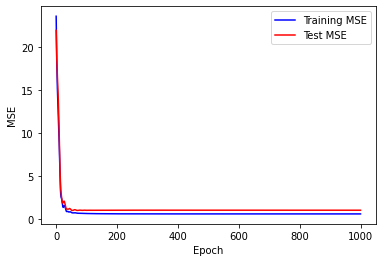

In [84]:
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.plot(X,Y_test,c="red",label="Test MSE")
plt.legend()
plt.show()
#overfittig 없음!

# Bias

In [90]:
 #bias 추가하기

rank = 10 #사용자 vector, 아이템 vector의 차원
numItems = items.max() + 1  #사용자수
numUsers = users.max() + 1  #아이템수
P = torch.randn(numItems, rank, requires_grad=True) #아이템 메트릭스 
Q = torch.randn(numUsers, rank, requires_grad=True) #사용자 메트릭스
bias_item = torch.randn(numItems, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)
mean = (ratings.sum() / len(ratings)).item()


#기본 MatrixFactorization구현

# Matplotlib으로epoch마다TrainingMSE그려보기
X = []
Y = []
Y_test=[] # Matplotlib으로 epoch마다 TestMSE 그려보기

# Regularization 추가하기
lambda1 = 0.0001
lambda2 = 0.0001

lambda3 = 0.0001 #bias_item
lambda4 = 0.0001  #bias_user


optimizer = torch.optim.Adam([P, Q, bias_item, bias_user], lr=0.1)
for epoch in range(1001):
  hypothesis = torch. sum(P[items] * Q[users], dim= 1)\
  + mean + bias_item[items] +bias_user[users]
  mse = F.mse_loss(hypothesis ,ratings)
  
  cost = mse+lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2)+\
  lambda3 * torch.sum(bias_item ** 2) + lambda4 * torch.sum(bias_user ** 2)

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()
  X.append(epoch)
  Y.append(mse.item()) #training mse
  
   
  with torch.no_grad():
    hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1)+\
    + mean + bias_item[items_test] +bias_user[users_test]
    mse_test = F.mse_loss(hypo_test, ratings_test)
    Y_test.append(mse_test.item())
  if epoch % 100 == 0: 
    print("epoch: {}, mse: {}, mse_test: {}" .format(epoch, mse,mse_test))

epoch: 0, mse: 13.24591064453125, mse_test: 10.548763275146484
epoch: 100, mse: 0.6057204008102417, mse_test: 0.8808915019035339
epoch: 200, mse: 0.5780660510063171, mse_test: 0.8724049925804138
epoch: 300, mse: 0.5749489068984985, mse_test: 0.8682328462600708
epoch: 400, mse: 0.5737254619598389, mse_test: 0.8662109375
epoch: 500, mse: 0.5731871128082275, mse_test: 0.8666783571243286
epoch: 600, mse: 0.5729420781135559, mse_test: 0.8673415184020996
epoch: 700, mse: 0.5727258324623108, mse_test: 0.8677353858947754
epoch: 800, mse: 0.5725242495536804, mse_test: 0.8679314255714417
epoch: 900, mse: 0.5723900198936462, mse_test: 0.8681086301803589
epoch: 1000, mse: 0.5723158121109009, mse_test: 0.8682851791381836


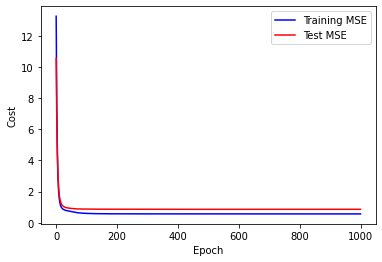

In [91]:
plt.ylabel("Cost")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.plot(X,Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()

#TEST MSE 최소로 만들기

In [116]:
 #bias 추가하기

rank = 10 #rank는 mse의 범위
numItems = items.max() + 1  #사용자수
numUsers = users.max() + 1  #아이템수
P = torch.randn(numItems, rank, requires_grad=True) #아이템 메트릭스 
Q = torch.randn(numUsers, rank, requires_grad=True) #사용자 메트릭스
bias_item = torch.randn(numItems, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)
mean = (ratings.sum() / len(ratings)).item()


#기본 MatrixFactorization구현

# Matplotlib으로epoch마다TrainingMSE그려보기
X = []
Y = []
Y_test=[] # Matplotlib으로 epoch마다 TestMSE 그려보기

# Regularization 추가하기
lambda1 = 0.0001
lambda2 = 0.0001
''' case1: 늘렸는데 큰 값의 비중이 높아져서 그런가 값이 커짐
lambda3 = 0.001 #bias_item
lambda4 = 0.001  #bias_user
'''

lambda3 = 0.00009 #bias_item
lambda4 = 0.00009  #bias_user



optimizer = torch.optim.Adam([P, Q, bias_item, bias_user], lr=0.1)
for epoch in range(1001):
  hypothesis = torch. sum(P[items] * Q[users], dim= 1)\
  + mean + bias_item[items] +bias_user[users]
  mse = F.mse_loss(hypothesis ,ratings)
  
  cost = mse+lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2)+\
  lambda3 * torch.sum(bias_item ** 2) + lambda4 * torch.sum(bias_user ** 2)

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()
  
  
   
  with torch.no_grad():
    X.append(epoch)
    Y.append(mse.item()) #training mse
    hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1)+\
    + mean + bias_item[items_test] +bias_user[users_test]
    mse_test = F.mse_loss(hypo_test, ratings_test)
    Y_test.append(mse_test.item())
  if epoch % 100 == 0: 
    print("epoch: {}, mse: {}, mse_test: {}" .format(epoch, mse,mse_test))



  

epoch: 0, mse: 13.167290687561035, mse_test: 10.433516502380371
epoch: 100, mse: 0.6025863289833069, mse_test: 0.8751099705696106
epoch: 200, mse: 0.5768218636512756, mse_test: 0.872869610786438
epoch: 300, mse: 0.5731487274169922, mse_test: 0.8719893097877502
epoch: 400, mse: 0.5721280574798584, mse_test: 0.871144711971283
epoch: 500, mse: 0.5717028975486755, mse_test: 0.8705981373786926
epoch: 600, mse: 0.5714956521987915, mse_test: 0.8696905374526978
epoch: 700, mse: 0.5714011192321777, mse_test: 0.8688993453979492
epoch: 800, mse: 0.571357011795044, mse_test: 0.8683700561523438
epoch: 900, mse: 0.571337103843689, mse_test: 0.8680714964866638
epoch: 1000, mse: 0.5713304877281189, mse_test: 0.8678775429725647


bias 를 이리저리 돌려도 mse_test가 낮아지기는 커녕 높아져만 갑니다..
인터넷에 구글링해본 결과 cross validation(교차검증)을 사용하면 된다고 찾긴하였지만
배우지 못한 내용이라 코드를 봐도 이해가 가지 않아.. 이렇게 글을 작성하게 되었습니다.